In [15]:
import numpy as np
import gymnasium as gym
import torch

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
# The "ipympl" backend is better, as it allows for interactiveness, but on some installations it does not work, then use "inline"
%matplotlib ipympl
# %matplotlib inline   

# this way of importing allow to reload/refresh the module later with importlib.reload(policy)
import policy as policy 
import memory as mem
from feedforward import Feedforward

In [16]:
import importlib
importlib.reload(mem)
importlib.reload(policy)

<module 'policy' from '/home/martius/docs/vorlesungen/RL/RL2024/Assignments/homework/6_gym_value-approx/6_gym_valueapprox/6-gym-valueapprox-solution/policy.py'>

Load environment, policy and memory.

In [17]:
env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
pi = policy.PDPolicy(env)
buffer = mem.Memory()

## Inspect the environment 

In [18]:
(s, _)  = env.reset()
for t in range(50):
    a = pi.get_action(s) 
    s_new, rew, term, trunc, _ = env.step(a)
    buffer.add_transition([s,a,rew,s_new, term, trunc])
    s = s_new

In [19]:
transitions = buffer.get_all_transitions()
states = np.vstack(transitions[:,0])
actions = transitions[:,1]
rewards = transitions[:,2]

Plot the trajectory: (state, action, reward)
 
 The state is [position, velocity] 

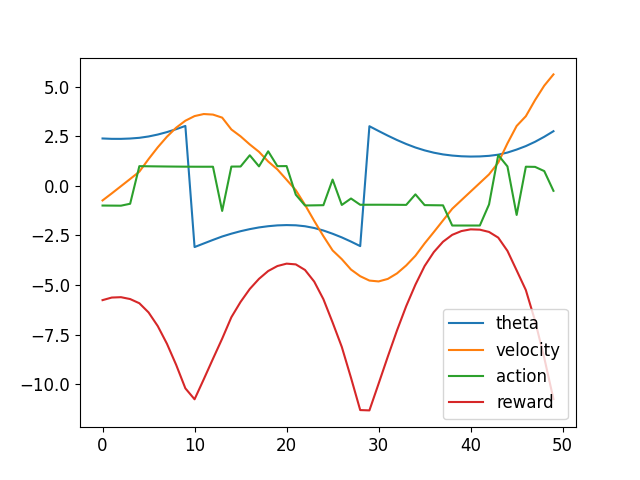

In [20]:
plt.figure()
#plt.plot(states[:,0], label="x")
#plt.plot(-states[:,1], label="y")
plt.plot(np.arctan2(states[:,1],states[:,0]), label="theta")
plt.plot(states[:,2], label="velocity")
plt.plot(actions, label="action")
plt.plot(rewards, label="reward")
plt.legend()

# Collect data

We do 500 rollouts a 100 timesteps with the black box policy. Nothing needs to be changed here.

In [21]:
env = gym.make('Pendulum-v1', g=9.81, render_mode=None)
for ep in range(500):
    # start a larger range initial conditions to see enough of the statespace
    s, _ = env.reset(options={"y_init": 4})
    for t in range(100):
        a = pi.get_action(s) 
        s_new, rew, term, trunc, _ = env.step(a)
        buffer.add_transition([s,a,rew,s_new, term, trunc])
        s = s_new

In [22]:
buffer.size

50050

# Fit value function

The value function fitting class. Here, you need to fill in the blank parts

In [23]:
class ValueFunction(Feedforward):
    def __init__(self, observation_dim, hidden_sizes=[100,100]):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, output_size=1)
        self.optimizer=torch.optim.Adam(self.parameters(), lr = 0.0002, eps=0.000001)
        self.loss = torch.nn.MSELoss()
    
    def fit(self, observations, targets):
        self.train() # put model in training mode
        self.optimizer.zero_grad()
        # Forward pass
        pred = self.forward(torch.from_numpy(observations).float())
        # Compute Loss
        loss = self.loss(pred, torch.from_numpy(targets).float())
        # Backward pass
        loss.backward()
        self.optimizer.step()
        return loss.item()

Visualization of the value function. Nothing needs to be changed here.

In [41]:
def plot_value_function(value_function):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(-np.pi/2,np.pi/2)
    yys =np.linspace(-3,3)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.asarray([np.cos(XX.ravel()),np.sin(XX.ravel()),YY.ravel()]).T
    print(dots.shape)
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values =value_function.predict(dots).reshape(XX.shape)

    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(elev=20, azim=45, roll=0)
    ax.set_xlabel('angle')
    ax.set_ylabel('angle velocity')
    ax.set_zlabel('value')
    # plt.colorbar(cmap=cm.coolwarm)
    return fig

In [42]:
valuefunc = ValueFunction(observation_dim=env.observation_space.shape[0])

(2500, 3)


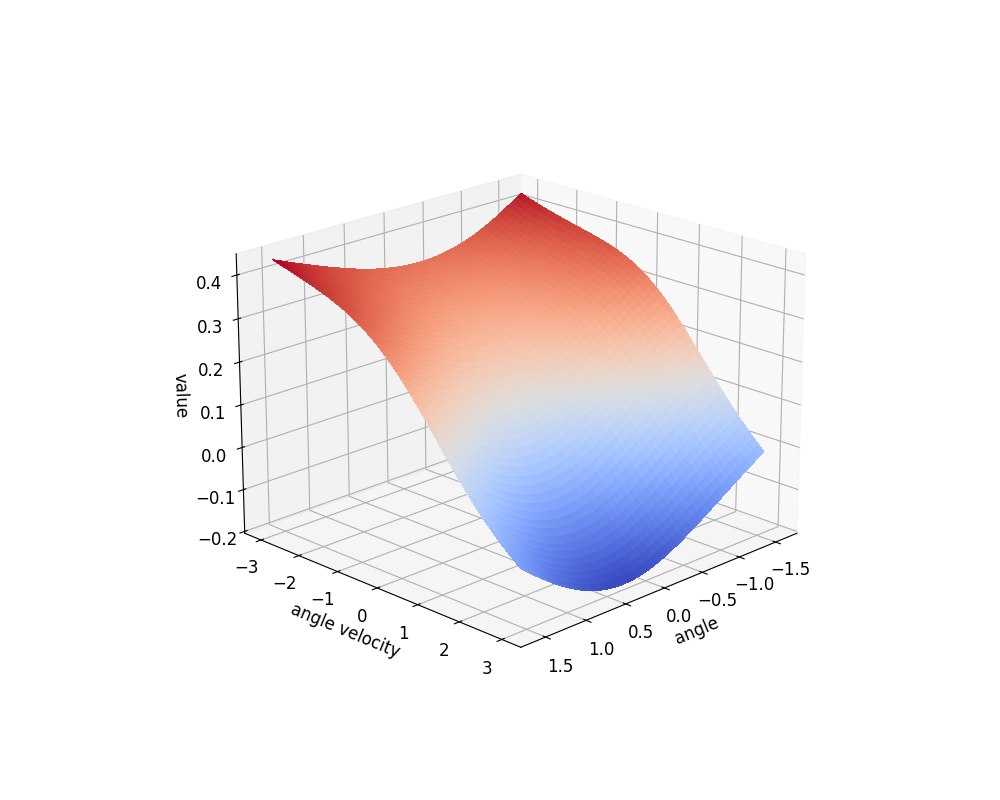

In [43]:
fig1 = plot_value_function(value_function=valuefunc)

In [27]:
fig1.savefig("value_approx_before_training.pdf", bbox_inches="tight")

Fitting routine of the value function. Fill in the blank parts.

In [44]:
plt_fit = []

In [45]:
iter_fit = 2000
gamma=0.95
# gamma=0.5
for i in range(iter_fit):

    # sample from the replay buffer
    data=buffer.sample(batch=512)
    s = np.stack(data[:,0]) # s_t
    sp = np.stack(data[:,3]) # s_t+1
    rew = np.stack(data[:,2])[:,None] # rew
    
    values = valuefunc.predict(s)
    valuesp = valuefunc.predict(sp)
    # target
    td_target = rew+gamma*valuesp

    # optimize the lsq objective
    fit_loss = valuefunc.fit(s, td_target)
    plt_fit.append(fit_loss)
    

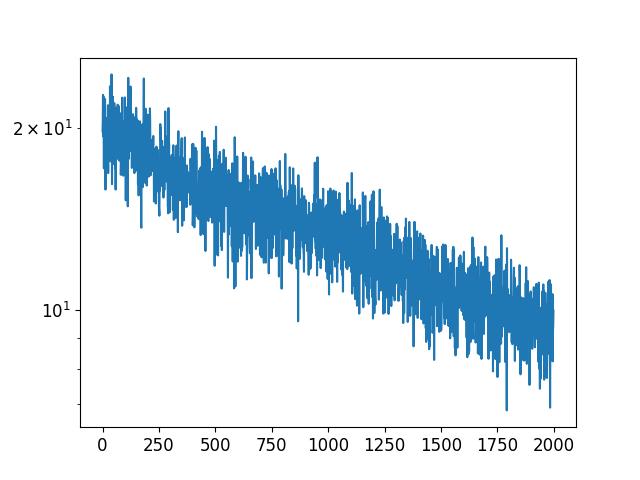

In [46]:
# plot the loss
fig_loss=plt.figure()
plt.yscale("log")
plt.plot(range(len(plt_fit)), plt_fit)

In [47]:
fig_loss.savefig(f"training_loss-gamma{gamma}.pdf", bbox_inches="tight")

(2500, 3)


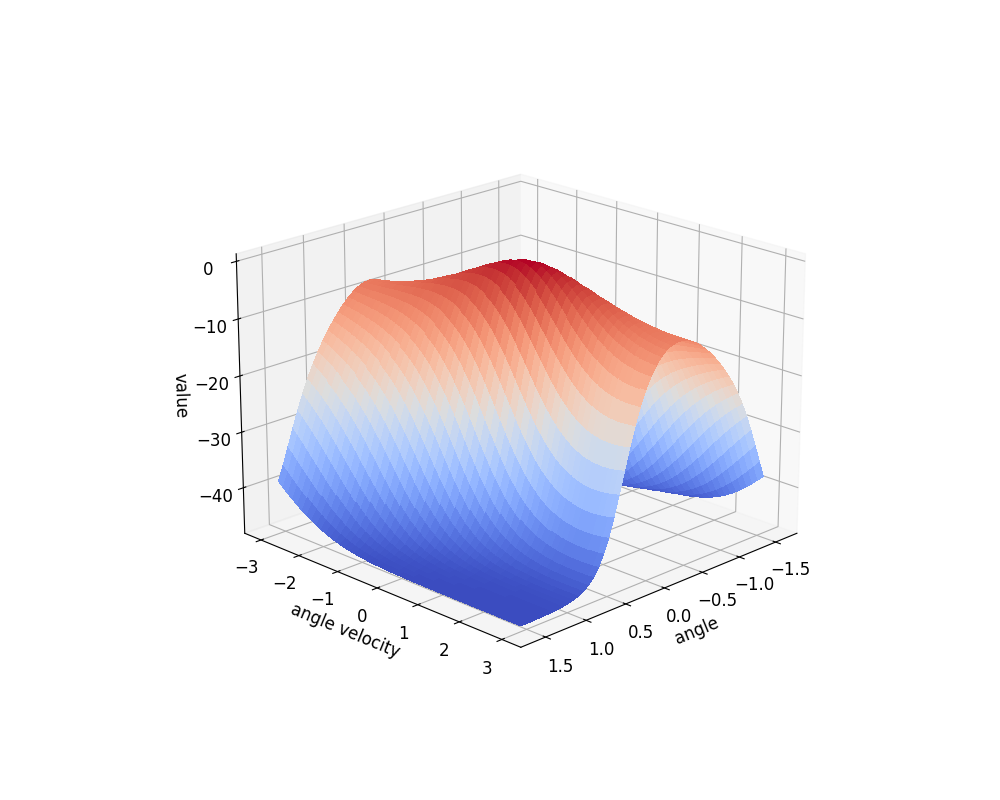

In [48]:
fig = plot_value_function(value_function=valuefunc)

In [49]:
fig.savefig(f"value_approx_after_training-gamma{gamma}.pdf", bbox_inches="tight")
